In [1]:
%matplotlib notebook
import numpy as np
import pickle
import os
import json
import matplotlib.pylab as plt
from copy import deepcopy as dc
from math import factorial
from tqdm import tqdm_notebook as tqdm
import time
import networkx as nx

In [150]:
class MDP():
    def __init__(self, y = 0.9, mdp_root='./mdps/', load=False, filepath=-1, read_path=-1):
        self.config = {'mdp_root': mdp_root, 'y': y, 'epsilon':0.01}
        
        if load:
            self.load(filepath)
            return
        
        N = int(input("Number of states:\t"))
        A = int(input("Number of unique actions:\t"))
        M = int(input("Number of edges:\t"))
        
        self.N = N
        self.A = A
        self.p  = np.array([ [[0 for i in range(N+1)] for j in range(A+1)] for k in range(N+1) ], dtype=np.float64)
        self.r  = np.array([ [[-10000000 for i in range(N+1)] for j in range(A+1)] for k in range(N+1) ], dtype=np.float64)
        self.pi = np.array([ [0 for i in range(N+1)] for j in range(A+1) ], dtype=np.float64)
        self.vstar  = np.array([ 0 for i in range(N+1) ], dtype=np.float64)
        self.actions = [[] for i in range(N+1)]
        self.policy = [0 for i in range(N+1)]
        
        try:
            os.mkdir(mdp_root)
        except Exception as e:
            print("Warning: " + str(e))
            
        #### init p, r, actions
        if read_path!=-1:
            fil = open(read_path, 'r')
            
        for i in range(M):
            if read_path == -1:
                s_dash, a, s, p, r = map(float, input("(s_dash, a, s, p, r):\t").split(' '))
            else:
                s_dash, a, s, p, r = map(float, fil.readline().split(','))
                
            s_dash, a, s = map(int, [s_dash, a, s])
            self.p[s_dash, a, s] = p
            self.r[s_dash, a, s] = r
            self.actions[s].append(a)
        
        if read_path!=-1: fil.close()
            
        #### init policy
        for state in range(N):
            self.actions[state] = list(set(self.actions[state]))
            num_actions = len(self.actions[state])
            if num_actions == 0: continue
                
#             for action in self.actions[state]:
#                 self.pi[action, state] = 1/num_actions
                
        print("Policy initiliased to all 0 for each state.")
        
        #### rpi ppi
        self.rpi = np.sum(self.pi * np.sum(self.p * self.r, axis=0), axis=0)[:,np.newaxis]
        self.ppi = np.sum(self.pi * self.p, axis=1)
    
    def save(self, filename=-1):
        if filename==-1: filename = input('Filename: ')
        path = self.config['mdp_root']+filename
        with open(path,'wb') as fil:
            pickle.dump(self.__dict__, fil)
            
    def load(self, filepath = -1):
        if filepath==-1:
            mdp_root = self.config['mdp_root']
            files = os.listdir(mdp_root)
            for i in range(len(files)):
                if files[i][0]=='.': continue
                print("{0}.\t{1}".format(i, files[i]))
                
            while True:
                try:
                    n = int(input("Load which mdp?\t"))
                    if n>=len(files):
                        raise Exception()
                    break
                except Exception as e:
                    print("Not a valid option")
            
            filepath = files[n]
        
        filepath = self.config['mdp_root'] + filepath
        
        with open(filepath, 'rb') as fil:
            self.__dict__.update(pickle.load(fil))
            
    def policy_to_pi(self, policy=[]):
        pi = np.zeros((self.pi.shape[0], self.pi.shape[1]))
        if len(policy)==0: policy = self.policy 
            
        for i in range(self.N+1):
            if policy[i] != 0:
                pi[policy[i], i] = 1
        return pi
                
    def F_pi(self,v, y):
        self.rpi = np.sum(self.pi * np.sum(self.p * self.r, axis=0), axis=0)[:,np.newaxis]  
        self.ppi = np.sum(self.pi * self.p, axis=1)
        return self.rpi + y*np.transpose(self.ppi)@v
    
    def F(self,v, y):
        v = np.reshape(v, (v.shape[0], 1, 1))
        q = np.sum(self.r * self.p, axis=0) + y*np.sum(self.p * v, axis=0)
        return np.max(q, axis=0)
    
    def value_iteration(self, plot_error=False, plot_vals=False, max_iter=-1, debug=False):
        v = np.zeros(shape=(self.N+1,1))
        er = self.config['epsilon']*(1-self.config['y'])/(2*self.config['y'])
        
        fige = -1
        figv = -1
        d = []
        x = []
        it = 1
        if plot_error:
            fige = plt.figure()
        
        if plot_vals:
            figv = plt.figure()
            xv = np.arange(0, self.N+1)
            
        delta = er+1
        while delta>er and it!=max_iter:
            v_new = self.F(v, self.config['y'])
            delta = np.max(np.abs(v_new - v))
            d.append(delta)
            x.append(it)
            
            if plot_error:
                plt.plot(x,d)
                fige.canvas.draw()
            
            if plot_vals:
                plt.plot(xv,v_new)
                figv.canvas.draw()
                
            it+=1
            v = v_new
            if debug:
                print(v)
                print(self.get_policy(v, self.config['y'], debug=debug))
                t = input("continue?")
        
        plt.figure()
        plt.plot(x,d)
        
        self.policy = self.get_policy(v, self.config['y'])
        return self.policy
    
    def get_policy(self, v, y, debug=False):
        v = np.reshape(v, (v.shape[0], 1, 1))
        q = np.sum(self.r * self.p, axis=0) + y*np.sum(self.p * v, axis=0)
        pi = self.A - np.argmax(q[::-1,:], axis = 0)
        
        l = []
        print(q.shape)
        for i in range(pi.shape[0]):
            cur = []
            for j in range(q.shape[0]):
                if q[pi[i]][i] == q[j][i]:
                    cur.append(j)
            if debug: print(cur)
                
        return pi
    
    def evaluate_policy(self, v, epsilon):
        delta = epsilon+1
        while delta>epsilon:
            v_new = self.F_pi(v, y=self.config['y'])
            delta = np.max(np.abs(v_new-v))
            v = v_new
            
        return v
    
    def policy_iteration(self):
        v = np.random.randint(5, size=(self.N+1,1))
        stable = False
        
        while not stable:
            stable = True
            v = self.evaluate_policy(v, self.config['epsilon'])
            policy = self.get_policy(v, self.config['y'])
            pi = self.policy_to_pi(policy)
                        
            for i in range(len(self.policy)):
                if policy[i]!=self.policy[i]:
                    stable=False
                    break
                    
            self.pi = pi
            self.policy = policy
            print('---', self.pi)
            self.vstar = v
            
        return self.policy
            

## Jack Rental

In [3]:
rental1 = 3
rental2 = 4
return1 = 3
return2 = 2

a = np.linspace(1, 15, num=15, dtype=np.float64)[:,np.newaxis]
def poisson(l, a):
    return np.exp(-l)*np.power(l,a)/(np.cumprod(a)[:,np.newaxis])

<IPython.core.display.Javascript object>


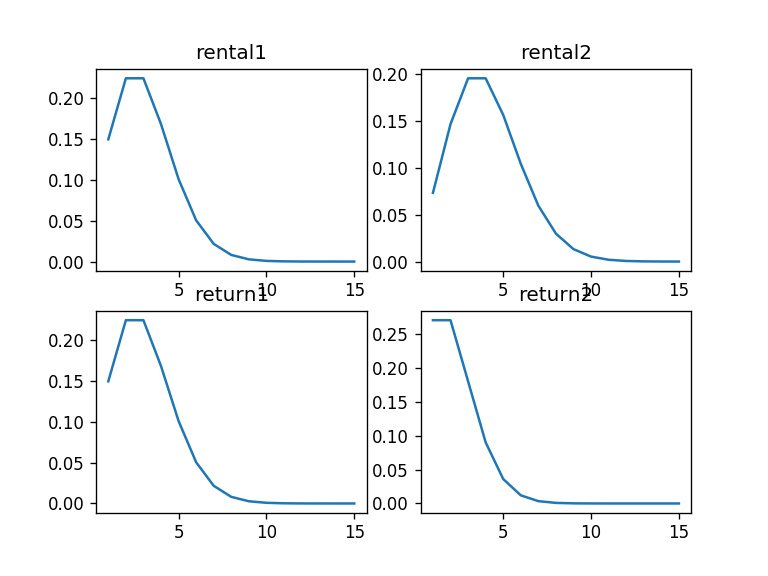

[0.22404181]
[0.19536681]


In [591]:
b = poisson(rental1, a)
plt.subplot(2,2,1)
plt.title('rental1')
plt.plot(a,b)
print(b[2])

b = poisson(rental2, a)
plt.subplot(2,2,2)
plt.title('rental2')
plt.plot(a,b)
print(b[2])

b = poisson(return1, a)
plt.subplot(2,2,3)
plt.title('return1')
plt.plot(a,b)

b = poisson(return2, a)
plt.subplot(2,2,4)
plt.title('return2')
plt.plot(a,b)

plt.show()

In [96]:
class jack_rental():
    def __init__(self, rental1, return1, rental2, return2):
        self.max_returns = 11
        self.max_rentals = 11
        self.rental1 = rental1
        self.rental2 = rental2
        self.return1 = return1
        self.return2 = return2
        self.max_cars = 20
        self.max_mov = 5
        self.rent_reward = 10
        self.mov_cost = 2
        self.pr = {}  
        
        self.poisson = []
        for k in range(max(self.max_rentals, self.max_returns)+1):
            cur = [0 for i in range(max(rental1, return1, rental2, return2)+1)]
            for l in [rental1, return1, rental2, return2]:
                cur[l] = self.poiss(k,l)
            self.poisson.append(cur)
                
    def get_map(self, state):
        return state[0]*(self.max_cars+1)+ state[1]
    
    def poiss(self,k,l):
        a = np.exp(-l)*np.power(l,k)/factorial(k)
        return a
    
    def proc_state(self,state):
        old_state = dc(state)
        
        for mov in range(-min(self.max_mov, old_state[1]), min(self.max_mov, old_state[0])+1):
            state = [min(old_state[0]-mov, self.max_cars), min(old_state[1]+mov, self.max_cars)]
            
            for return1 in range(self.max_returns+1):
                for return2 in range(self.max_returns+1):
                    for rental1 in range(self.max_rentals+1):
                        for rental2 in range(self.max_rentals+1):
                            p = self.poisson[return1][self.return1]*self.poisson[return2][self.return2]\
                                *self.poisson[rental1][self.rental1]*self.poisson[rental2][self.rental2]
                           
                            new_state = dc(state)
                            act_rent1 = min(rental1, state[0])
                            act_rent2 = min(rental2, state[1])
                            
                            new_state[0] = min(state[0] - act_rent1 + return1, self.max_cars)
                            new_state[1] = min(state[1] - act_rent2 + return2, self.max_cars)
                            
                            r = (act_rent1+act_rent2)*self.rent_reward - np.abs(mov)*self.mov_cost
                            
                            ns = self.get_map(new_state)
                            os = self.get_map(old_state)
                            
#                             print(new_state, mov, state, old_state, r, p, act_rent1+act_rent2, rental1, rental2)
                            if (ns, mov, os) in self.pr:
                                self.pr[(ns, mov, os)]['p'] += p
                                self.pr[(ns, mov, os)]['r'] += p*r
                            else:
                                self.pr[(ns, mov, os)] = {'p':p, 'r':p*r}
                                
    def gen_states(self):
        for i in tqdm(range(self.max_cars+1)):
            for j in tqdm(range(self.max_cars+1)):
                self.proc_state((i,j))
        
        for i in tqdm(self.pr):
            self.pr[i]['r']/=self.pr[i]['p']

In [97]:
jr = jack_rental(rental1, return1, rental2, return2)

In [98]:
jr.gen_states()

In [102]:
with open('jack_rental.pickle', 'wb') as fil:
    pickle.dump(jr.pr, fil)

In [104]:
with open("jr3.txt", 'w') as fil:
    for i in tqdm(jr.pr):
        fil.write("{},{},{},{},{}\n".format(i[0], i[1]+jr.max_mov+1, i[2], jr.pr[i]['p'], jr.pr[i]['r']))
#         print(i, jr.pr[i])

In [105]:
len(jr.pr.keys())

1203103

In [106]:
mdp = MDP(y = 0.9, read_path='./jr3.txt')

Number of states:	441
Number of unique actions:	11
Number of edges:	1203103
Policy initiliased to all 0 for each state.


In [115]:
mdp.policy_iteration()

--- [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


array([ 6,  6,  6,  6,  6,  6,  6,  6,  5,  5,  4,  4,  4,  3,  3,  3,  3,
        3,  2,  2,  2,  6,  6,  6,  6,  6,  6,  6,  6,  6,  5,  5,  5,  4,
        4,  4,  4,  4,  3,  3,  3,  3,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  5,  5,  5,  5,  5,  4,  4,  4,  4,  4,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  5,  5,  5,  5,  5,  4,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  5,  5,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  8,  8,  7,  7,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  9,  8,  8,  7,  7,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  9,  9,
        8,  8,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6, 10,  9,  9,  8,  8,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6, 10, 10,  9,  9,  8,  7,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6

In [116]:
ar = [ [0 for i in range(jr.max_cars+1)] for j in range(jr.max_cars+1) ]
var = [ [0 for i in range(jr.max_cars+1)] for j in range(jr.max_cars+1) ]
for i in range(len(mdp.policy)-1):
    p1 = (int)(i/(jr.max_cars+1))
    p2 = i%(jr.max_cars+1)
#     if mdp.policy[i]==7:
    ar[p1][p2] = mdp.policy[i] - jr.max_mov-1
    var[p1][p2] = mdp.vstar[i]
ar = np.array(ar)

<IPython.core.display.Javascript object>


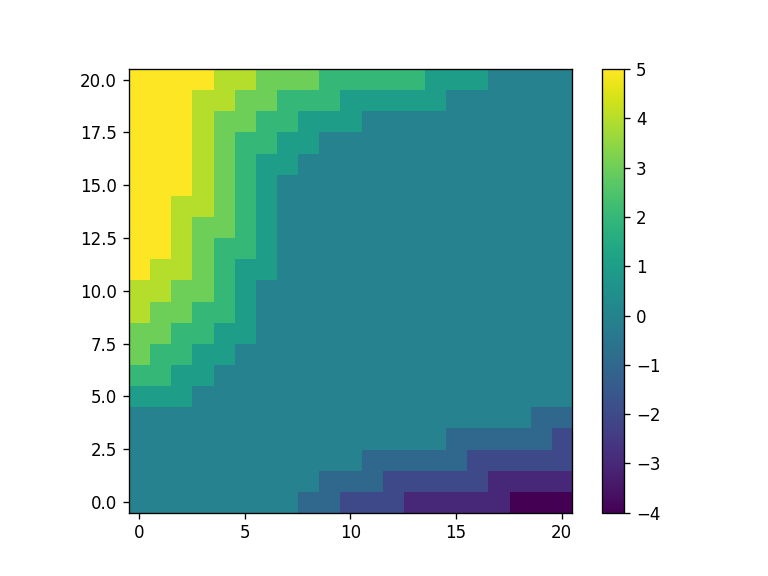

In [117]:
plt.imshow(ar)
plt.colorbar(orientation='vertical')
plt.gca().invert_yaxis()
plt.show()

In [110]:
mdp.save()

Filename: jack_rental


## Gambler's Problem

In [151]:
class gambler_problem():
    def __init__(self, max_amt, ph):
        self.max_amt = max_amt
        self.ph = ph
        
        self.pr = {}
    
    def proc_state(self, state):
        old_state = dc(state)
        for stake in range(min(state, self.max_amt-state)+1):
            state = old_state - stake
            
            # if heads
            new_state = state+2*stake
            if (new_state, stake, old_state) not in self.pr:
                self.pr[(new_state, stake, old_state)] = {'p':self.ph, 'r': 0}
            else:
                self.pr[(new_state, stake, old_state)]['p'] += self.ph
#             if new_state == self.max_amt: self.pr[(new_state, stake, old_state)]['r'] = 1
            
            # if tails
            new_state = state
            if (new_state, stake, old_state) not in self.pr:
                self.pr[(new_state, stake, old_state)] = {'p':1-self.ph, 'r': 0}
            else:
                self.pr[(new_state, stake, old_state)]['p'] += 1-self.ph
            
#             if new_state == self.max_amt: self.pr[(new_state, stake, old_state)]['r'] = 1
            
    def gen_states(self):
        for i in tqdm(range(self.max_amt)):
            self.proc_state(i)
        self.pr[(self.max_amt+1, 0, self.max_amt)] = {'p':1, 'r':1}
        
    def write(self, filepath=-1):
        if filepath==-1: filepath = input("Filepath: ")
        with open(filepath, 'w') as fil:
            for i in tqdm(self.pr):
                fil.write("{},{},{},{},{}\n".format(i[0], i[1], i[2], self.pr[i]['p'], self.pr[i]['r']))

    def save(self, filepath=-1):
        if filepath==-1: filepath = input("Filepath: ")
        with open(filepath, 'wb') as fil:
            pickle.dump(self.pr, fil)

In [159]:
gp = gambler_problem(max_amt = 100, ph = 0.6)

In [160]:
gp.gen_states()

In [161]:
gp.write('./gp1.txt')

In [162]:
gp.pr[(100,1,99)]

{'p': 0.6, 'r': 0}

In [163]:
mdp = MDP(y=1, read_path='./gp1.txt')

Number of states:	101
Number of unique actions:	100
Number of edges:	5101
Policy initiliased to all 0 for each state.


<IPython.core.display.Javascript object>


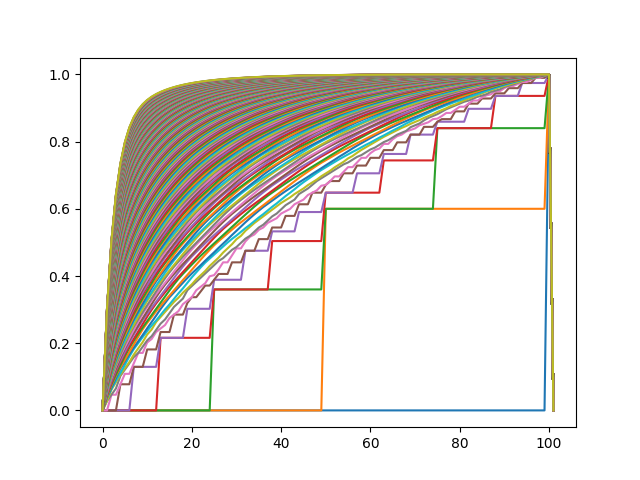

<IPython.core.display.Javascript object>


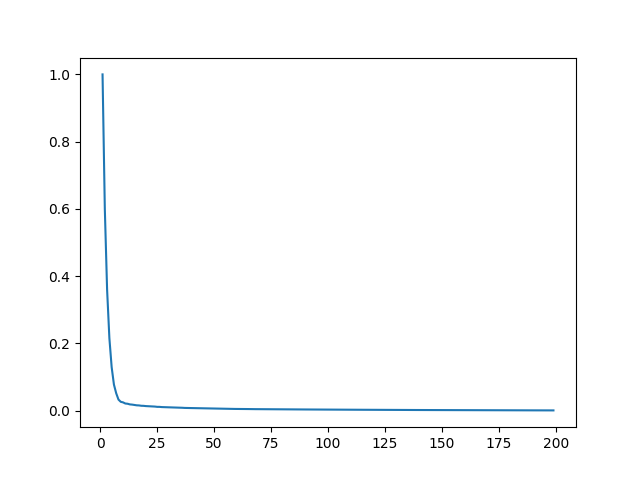

(101, 102)


array([100,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   0, 100])

In [170]:
mdp.config['y'] = 1
mdp.value_iteration(plot_vals=True, max_iter=200, debug=False)

In [92]:
mdp.policy.shape

(102,)

<IPython.core.display.Javascript object>


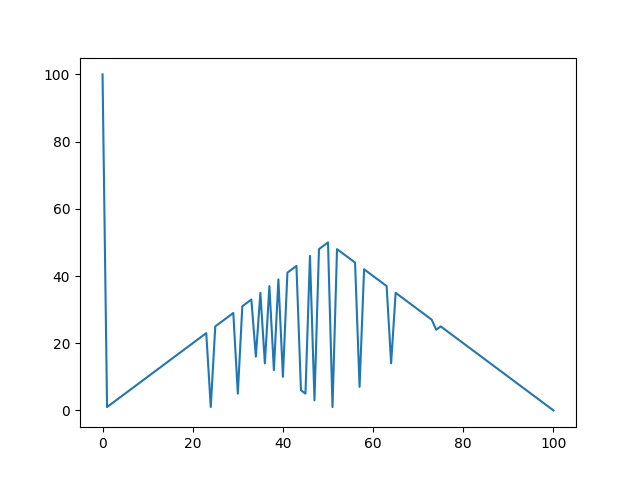

In [158]:
x = np.arange(0, 101)
y = mdp.policy[:-1]
plt.figure()
plt.plot(x,y)
plt.show()

In [123]:
a = np.array([[1,0,1],[2,0,2]])
print(a[::-1,:])
print(a)


[[2 0 2]
 [1 0 1]]
[[1 0 1]
 [2 0 2]]
